# Empirical Project

- Paola Antonicoli
- Michelangelo Saveriano

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!pip install pyLDAvis -qqq
!pip install sentence_transformers -qqq

import re

import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["figure.dpi"] = 75

from PIL import Image
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

import pyLDAvis
import pyLDAvis.sklearn

import nltk; nltk.download('punkt'); nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VAR

from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
%cd /content/drive/MyDrive/DDE
# from functions import *
from functions import tokenizer_stemmer, pkl_save, pkl_load, aggregate_signal, filter_dataframe_keeping_dates

/content/drive/MyDrive/DDE


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data

## Tweets Dataframe

In [ ]:
df = pkl_load('df')
df1 = pd.read_parquet('/content/drive/MyDrive/DDE/df1e.parquet')

In [ ]:
df1 = pd.read_parquet('/content/drive/MyDrive/DDE/df1e.parquet')
df2 = pd.read_parquet('/content/drive/MyDrive/DDE/df2e.parquet')
df1_columns = ['id', 'userid', 'body', 'tweet_dt', 'retweetcount', 'generator']
df2_columns = ['userBio', 'userDisplayName', 'userFollowers', 'userNumTweets', 'userVerified']
df = pd.concat([df1[df1_columns], df2[df2_columns]], axis=1)
df[['userBio', 'userDisplayName']] = df[['userBio', 'userDisplayName']].fillna('')
df['cleaned_body'] =  [' '.join(tokenizer_stemmer(x)) for x in df['body']]
df['year_month'] = [date[:7]  for date in df['tweet_dt']]
# df['tweet_dt'] = pd.to_datetime(df['tweet_dt'])

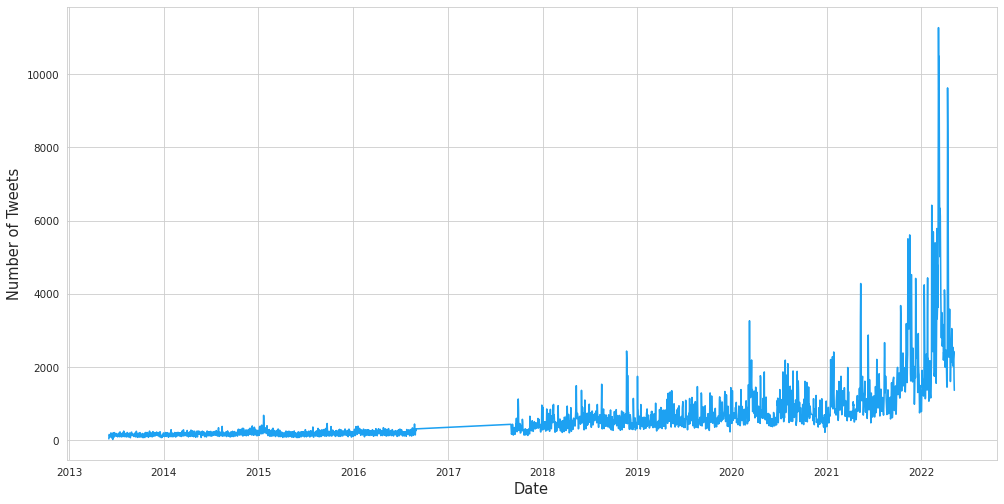

In [ ]:
sns.set_style('whitegrid')
sns.lineplot(x = pd.to_datetime(df.groupby(['tweet_dt']).count().index), 
             y = df.groupby(['tweet_dt']).count()['id'], color = '#1DA1F2')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.savefig('/content/drive/MyDrive/DDE/number_of_tweets.png', dpi=200)

plt.show()

In [ ]:
df

,id,userid,body,tweet_dt,retweetcount,generator,userBio,userDisplayName,userFollowers,userNumTweets,userVerified,cleaned_body,year_month
0,"tag:search.twitter.com,2005:1000073441666654209",id:twitter.com:1732019444,RT @ChrisLu44: “The increase in gas prices is ...,2018-05-25,108,Twitter Lite,,Batchelor Law Firm,185,23928,False,increas gas price felt heavili lower incom ame...,2018-05
1,"tag:search.twitter.com,2005:1000121300550062080",id:twitter.com:507547334,Heading into the Memorial Day weekend those in...,2018-05-25,0,LinkedIn,,Bill Dykes,48,208,False,head memori day weekend permian basin oil indu...,2018-05
2,"tag:search.twitter.com,2005:1000138945731031040",id:twitter.com:223565922,Retweeted Ron Paul (@RonPaul):\n\nInflation is...,2018-05-25,0,Facebook,"Student of Constitution & Common Law,Patriot #...",SoPhilly Fred 🇺🇸🏇,691,60587,False,retweet ron paul inflat vicious tax amp fed want,2018-05
3,"tag:search.twitter.com,2005:1000149645920735232",id:twitter.com:1252224511,"Oil prices fall on talk of hike in production,...",2018-05-25,0,Twitter Web Client,"Energy market analyst providing investors, tra...",Phil Flynn,4319,7963,False,oil price fall talk hike product rais hope dip...,2018-05
4,"tag:search.twitter.com,2005:1000209220619337728",id:twitter.com:2743142374,RT @malmuggeridge: The Abortion controversy is...,2018-05-26,136,Twitter for iPhone,Pro-life Libertarian atheist. If you're willin...,Dave O'Neill 🥃,531,9000,False,abort controversi vital relev surviv energi cr...,2018-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905893,"tag:search.twitter.com,2005:998918791919751169",id:twitter.com:718191269537792001,RT @JamesGlynnWSJ: Mortgage rates this week at...,2018-05-22,10,Twitter for iPad,"Stronger Portfolios, Wiser Diversification. \n...",Building Benjamins,54,744,False,mortgag rate week highest level sinc signal sh...,2018-05
1905894,"tag:search.twitter.com,2005:999387232157876224",id:twitter.com:877585625876221953,Wolfgang Puck High-Performance Com...: List Pr...,2018-05-23,0,dlvr.it,Bringing you around the clock deals directly t...,Feed You Deals,330,133541,False,wolfgang puck high perform com list price deal...,2018-05
1905895,"tag:search.twitter.com,2005:999467514886270976",id:twitter.com:925851324054372352,RT @WORLDSTAR: These gas prices way too high 😩...,2018-05-24,38,Twitter for Android,Taurus ♉❤,Chelebaby1😘😘,273,4527,False,gas price way high,2018-05
1905896,"tag:search.twitter.com,2005:999612775067541504",id:twitter.com:570416368,FBI's Inflation of Uncrackable Encrypted Phone...,2018-05-24,0,Twitter Web Client,Killing cybersecurity info-overload through al...,Metacurity - The End to Cybersec News Overload,1534,32266,False,fbi inflat uncrack encrypt phone stem contract...,2018-05


## Date Dataframe

In [ ]:
df_day = pd.DataFrame()
single_dates = df['tweet_dt'].unique()
df_day['date'] = single_dates
df_day['year_month'] = [date[:7]  for date in single_dates]
df_day['day'] = [ date[8:] for date in single_dates]
df_day['month'] = [ date[5:7] for date in single_dates]
df_day['year'] = [ date[:4] for date in single_dates]
df_day = df_day.sort_values('date').reset_index(drop=True)

In [ ]:
pkl_save('df_day', df_day)

In [ ]:
df_day = pkl_load('df_day')

## Inflation Dataframe


In [ ]:
df_mich = pd.read_csv('/content/drive/MyDrive/DDE/MICH.csv')
# df_mich['DATE'] = pd.to_datetime(df_mich['DATE'])
df_cpi = pd.read_csv('/content/drive/MyDrive/DDE/CPIAUCSL.csv')
# df_cpi['DATE'] = pd.to_datetime(df_cpi['DATE'])
df_cpi['INFLATION'] = df_cpi['CPIAUCSL'].pct_change()*100

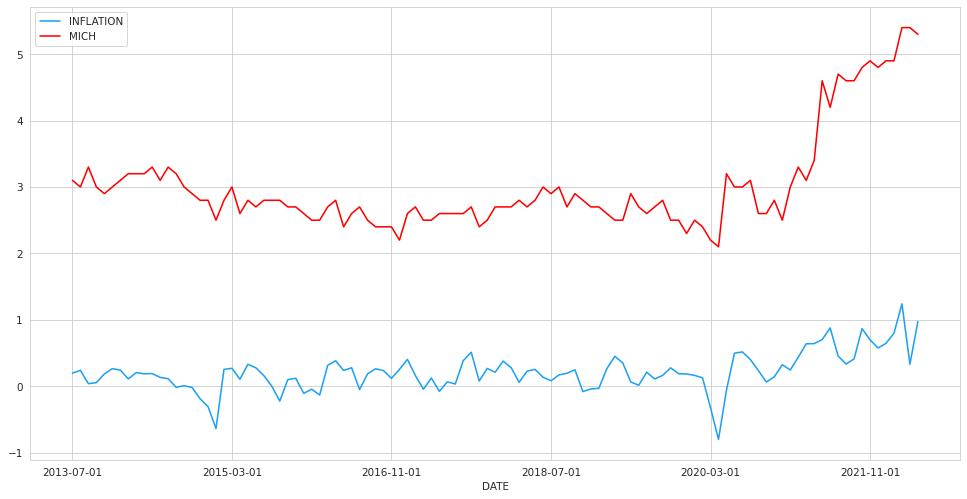

In [ ]:
df_inflation = pd.concat([
    df_cpi[(df_cpi['DATE'] > df['tweet_dt'].min()) & 
           (df_cpi['DATE'] < df['tweet_dt'].max())].drop(columns='CPIAUCSL').reset_index(drop=True),
    df_mich[(df_mich['DATE'] > df['tweet_dt'].min()) & 
            (df_mich['DATE'] < df['tweet_dt'].max())]['MICH'].reset_index(drop=True)
], axis=1).set_index('DATE')
df_inflation.plot(color = ['#1DA1F2', 'red'])
plt.savefig('/content/drive/MyDrive/DDE/inflation.png', dpi=200)

plt.show()

In [ ]:
pkl_save('df_inflation', df_inflation)

## Professionals Classification




In [ ]:
expert_flags = ['economist', 'economy', 'economic','econometrician', 'finance', 'journalist']
expert_flags = tokenizer_stemmer(' '.join(expert_flags))

In [ ]:
def is_professional(bio, flag=expert_flags):
  return bool(set(bio).intersection(set(flag)))

df['cleaned_bio'] =  [' '.join(tokenizer_stemmer(bio)) for bio in df['userBio']]
df['professional'] = [is_professional(bio.split(' ')) for bio in df['cleaned_bio']]

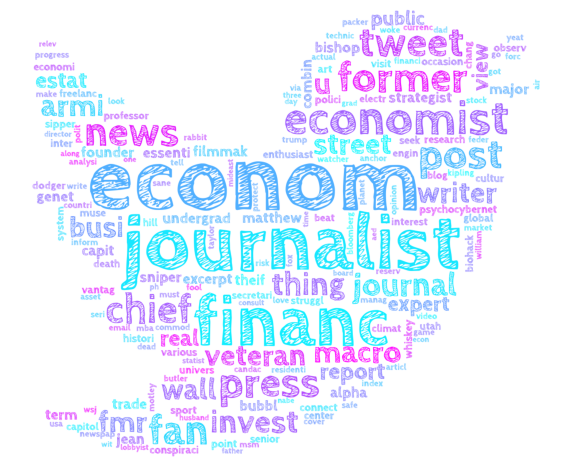

In [ ]:
twitter_mask = (np.array(Image.open('/content/drive/MyDrive/DDE/twird.png')).mean(axis=-1) == 0) * 255
colors = ['#1da1f2', '#33aaf3', '#4ab3f4', '#60bdf5', '#77c6f7', '#8ed0f8', '#a4d9f9', '#bbe2fb', '#d1ecfc', '#e8f5fd'][::-1]
wordcloud = WordCloud(
                      font_path='/content/drive/MyDrive/DDE/cabinsketch/CabinSketch-Bold.ttf',
                      background_color='white',
                      mask=twitter_mask,
                      colormap = plt.cm.cool
            ).generate(' '.join(df.loc[df['professional'], 'cleaned_bio'].values[:20].tolist()))

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('/content/drive/MyDrive/DDE/twird.png', dpi=300)
plt.show()

In [ ]:
df['professional'].mean()

0.025630437725418675

## Bot Classification

In [ ]:
cursed_gen_roots = ['bot', 'crypto', 'stock', 'trend', 'price', 'click', 
                    'balance', 'trad', 'DiscreteDrone', 'candlestick', 
                    'auto', 'coin', 'market', 'token', 'invest']
cursed_generators =  [gen for root in cursed_gen_roots for gen in df['generator'].unique() if re.findall(root, gen.lower())]
official_generators = [gen for gen in df['generator'].unique() if re.findall('Twitter for', gen)] + ['Twitter Lite', 'Twitter Web Client', 'Twitter Web App']
news_generators = list({gen for gen in df['generator'].unique() if re.findall('new', gen)}.difference(cursed_generators))

Generator Identification

In [ ]:
# print('\n'.join(df1['generator'].unique().tolist())) # Print all generators
# 
# api_substr = 'Tweet'
# print({gen for gen in df['generator'].unique() if re.findall(api_substr, gen)}.difference(cursed_generators)) # Print all generators containing api_substr which aren't alredy in cursed_generators
# 
# api_generator = 'BidTweet'
# print('\n'.join(df[df['generator'] == api_generator].head()['body'].values.tolist())) # Print n tweet generated using api_generator

Filter tweeets according to generator

In [ ]:
df['bot'] = ~df['generator'].isin(official_generators)

In [ ]:
df['bot'].mean()

0.159000114381777

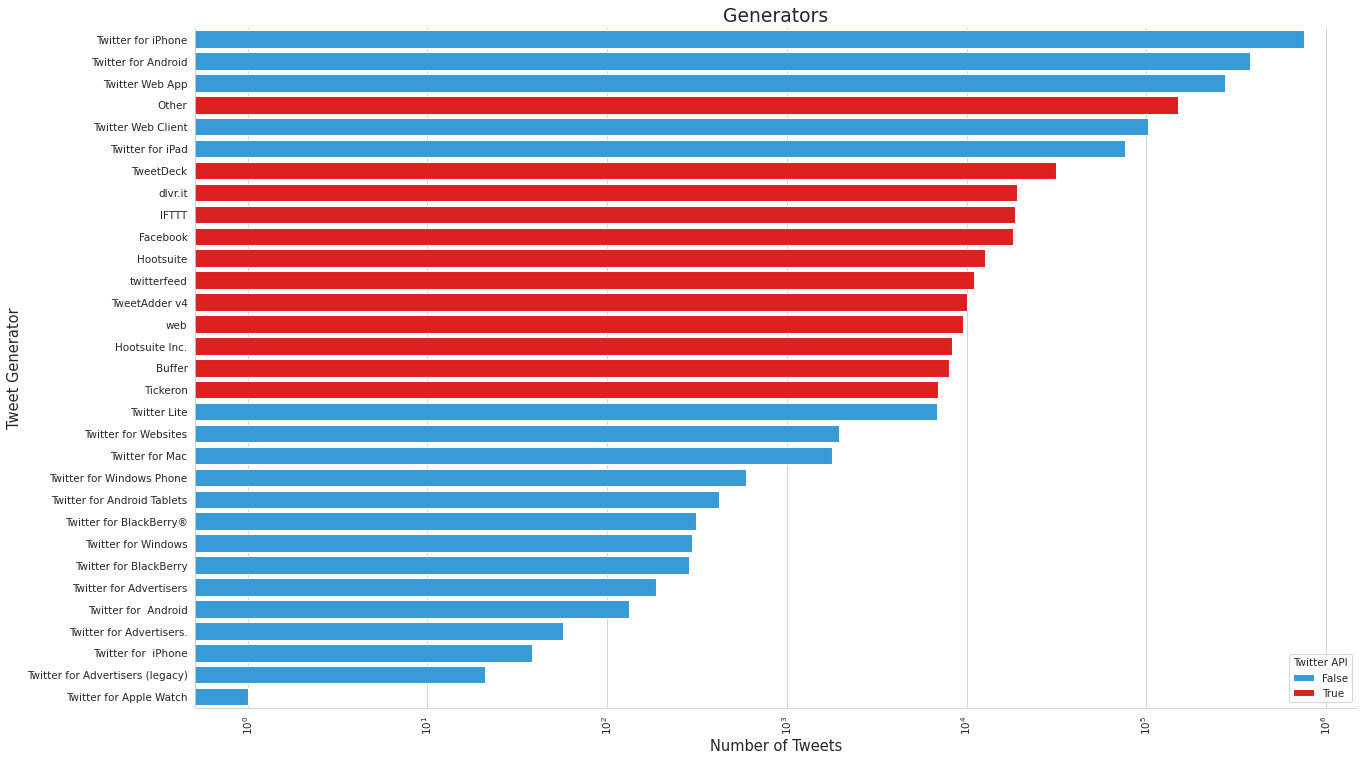

In [ ]:
generator_count = df.groupby('generator').count()[['id']].sort_values('id', ascending = False).reset_index()
generator_count['isbot'] = ~generator_count['generator'].isin(official_generators)
generator_count.loc[generator_count['isbot'] & (generator_count.index > 15), 'generator'] = 'Other'

plt.figure(figsize=(20,12))

sns.barplot(y = 'generator',x ='id', palette = ['#1DA1F2', 'red'], 
            data = generator_count.groupby(['generator', 'isbot']).sum().sort_values('id', ascending=False).reset_index(), 
            hue  = 'isbot', dodge=False )
plt.title('Generators', fontsize=18)
plt.legend(title='Twitter API')

plt.xlabel('Number of Tweets', fontsize=14)
plt.ylabel('Tweet Generator', fontsize=14)
plt.xticks(rotation=90)
plt.xscale('log')
plt.savefig('/content/drive/MyDrive/DDE/generators.png', dpi=200)

sns.despine();

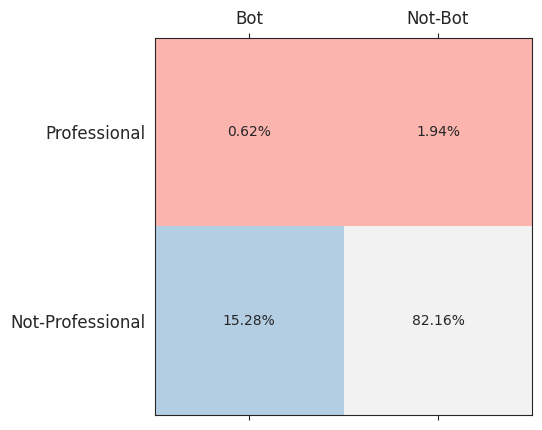

In [ ]:
sns.set_style('white')
prob_matrix = np.array([[(df['bot'] & df['professional']).mean(), 
                         ((~df['bot']) & df['professional']).mean()], 
                        [(df['bot'] & (~df['professional'])).mean(), 
                         ((~df['bot']) & (~df['professional'])).mean()]])

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

ax.matshow(prob_matrix, cmap=plt.cm.Pastel1)
plt.xticks([0, 1], ['Bot', 'Not-Bot'], fontsize=12)
plt.yticks([0, 1], ['Professional', 'Not-Professional'], fontsize=12)

for i in range(2):
    for j in range(2):
        c = prob_matrix[j,i]
        ax.text(i, j, str(round(c*100, 2)) + "%", va='center', ha='center')

plt.savefig('/content/drive/MyDrive/DDE/bot_confusion.png', dpi=300)


## Save Dataframes

In [ ]:
pkl_save('df', df) # Original

df_not_bot = filter_dataframe_keeping_dates(df, ~df['bot'], df_day)
pkl_save('df_NB', df_not_bot) # Not-Bot

df_professionals = filter_dataframe_keeping_dates(df, df['professional'], df_day)
pkl_save('df_P', df_professionals) # Professionals

df_professionals_not_bot = filter_dataframe_keeping_dates(df, (~df['bot']) & df['professional'], df_day)
pkl_save('df_P_NB', df_professionals_not_bot) # Professionals Not-Bot

## Load DF

In [ ]:
df = pkl_load('df')
df_not_bot = pkl_load('df_NB')
df_professionals = pkl_load('df_P')
df_professionals_not_bot = pkl_load('df_P_NB')

# EDA


In [ ]:
df = pkl_load('df')
df

,id,userid,body,tweet_dt,retweetcount,generator,userBio,userDisplayName,userFollowers,userNumTweets,userVerified,cleaned_body,year_month,professional,cleaned_bio,bot
0,"tag:search.twitter.com,2005:1000073441666654209",id:twitter.com:1732019444,RT @ChrisLu44: “The increase in gas prices is ...,2018-05-25,108,Twitter Lite,,Batchelor Law Firm,185,23928,False,increas gas price felt heavili lower incom ame...,2018-05,False,,False
1,"tag:search.twitter.com,2005:1000121300550062080",id:twitter.com:507547334,Heading into the Memorial Day weekend those in...,2018-05-25,0,LinkedIn,,Bill Dykes,48,208,False,head memori day weekend permian basin oil indu...,2018-05,False,,True
2,"tag:search.twitter.com,2005:1000138945731031040",id:twitter.com:223565922,Retweeted Ron Paul (@RonPaul):\n\nInflation is...,2018-05-25,0,Facebook,"Student of Constitution & Common Law,Patriot #...",SoPhilly Fred 🇺🇸🏇,691,60587,False,retweet ron paul inflat vicious tax amp fed want,2018-05,False,student constitut common law patriot nra ashal...,True
3,"tag:search.twitter.com,2005:1000149645920735232",id:twitter.com:1252224511,"Oil prices fall on talk of hike in production,...",2018-05-25,0,Twitter Web Client,"Energy market analyst providing investors, tra...",Phil Flynn,4319,7963,False,oil price fall talk hike product rais hope dip...,2018-05,False,energi market analyst provid investor trader i...,False
4,"tag:search.twitter.com,2005:1000209220619337728",id:twitter.com:2743142374,RT @malmuggeridge: The Abortion controversy is...,2018-05-26,136,Twitter for iPhone,Pro-life Libertarian atheist. If you're willin...,Dave O'Neill 🥃,531,9000,False,abort controversi vital relev surviv energi cr...,2018-05,False,pro life libertarian atheist will abrog someon...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905893,"tag:search.twitter.com,2005:998918791919751169",id:twitter.com:718191269537792001,RT @JamesGlynnWSJ: Mortgage rates this week at...,2018-05-22,10,Twitter for iPad,"Stronger Portfolios, Wiser Diversification. \n...",Building Benjamins,54,744,False,mortgag rate week highest level sinc signal sh...,2018-05,False,stronger portfolio wiser diversif disclaim see,False
1905894,"tag:search.twitter.com,2005:999387232157876224",id:twitter.com:877585625876221953,Wolfgang Puck High-Performance Com...: List Pr...,2018-05-23,0,dlvr.it,Bringing you around the clock deals directly t...,Feed You Deals,330,133541,False,wolfgang puck high perform com list price deal...,2018-05,False,bring around clock deal direct twitter timelin...,True
1905895,"tag:search.twitter.com,2005:999467514886270976",id:twitter.com:925851324054372352,RT @WORLDSTAR: These gas prices way too high 😩...,2018-05-24,38,Twitter for Android,Taurus ♉❤,Chelebaby1😘😘,273,4527,False,gas price way high,2018-05,False,taurus,False
1905896,"tag:search.twitter.com,2005:999612775067541504",id:twitter.com:570416368,FBI's Inflation of Uncrackable Encrypted Phone...,2018-05-24,0,Twitter Web Client,Killing cybersecurity info-overload through al...,Metacurity - The End to Cybersec News Overload,1534,32266,False,fbi inflat uncrack encrypt phone stem contract...,2018-05,False,kill cybersecur info overload algorithm projec...,False


## Tweets Time Distro


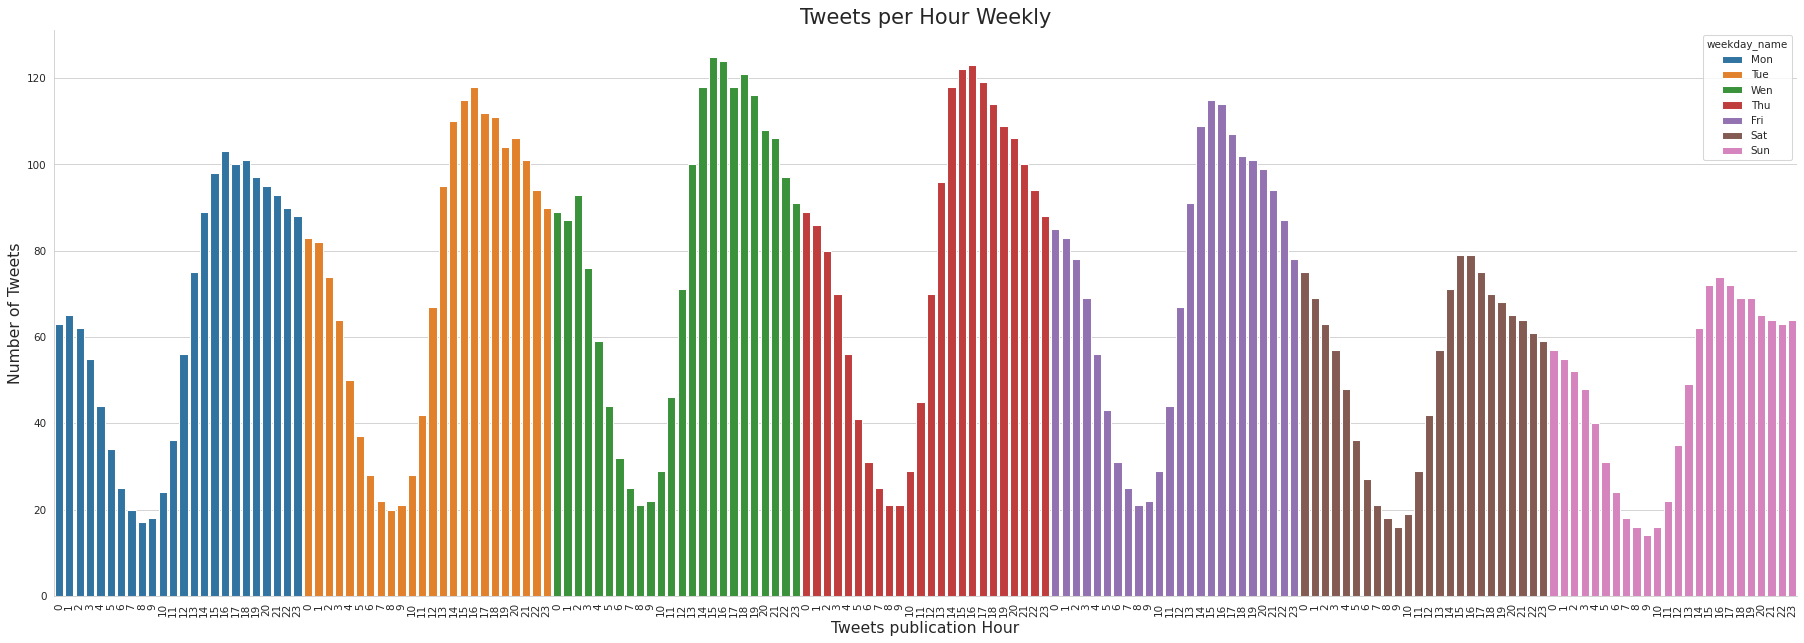

In [ ]:

#df1['postedtime'] = [ ' '.join(d[:-1].split('T')) for d in df1['postedtime'] ]
df1['postedtime'] = pd.to_datetime(df1['postedtime'], format='%Y-%m-%d %H:%M:%S.%f')
d_day = {0:'Mon', 1:'Tue', 2 : 'Wen', 3:'Thu', 4 :'Fri', 5: 'Sat', 6 : 'Sun'}
df_hour = pd.DataFrame({'hour':df1['postedtime'].dt.hour, 'minute': df1['postedtime'].dt.minute, 'id': df1['id']})
df_hour['weekday'] = list(map(lambda x : x.weekday() , df1['postedtime']))

df_hour = df_hour.groupby(['weekday','hour']).count().reset_index()
df_hour['weekday_name'] = list(map(lambda x : d_day[x], df_hour['weekday']))

df_hour = df_hour.sort_values(['weekday', 'hour'])

df_hour['day-hour'] = list(map(lambda x,y: x + str(y), df_hour['weekday_name'], df_hour['hour']))
df_hour['id']= df_hour['id']//len(df_hour)

plt.figure(figsize=(30,10))

g = sns.barplot(x='day-hour', y = 'id',ci = None,data  = df_hour, hue = 'weekday_name',dodge  = False)
g.set_xticklabels(df_hour['hour'])

plt.title('Tweets per Hour Weekly', fontsize = 20)
plt.ylabel('Number of Tweets', fontsize = 15)
plt.xlabel('Tweets publication Hour', fontsize = 15)
plt.xticks(rotation=90)
plt.savefig('/content/drive/MyDrive/DDE/TweetsperHourWeekly.png', dpi=300)

sns.despine();

In [ ]:
df_hour['id']/len(df_hour)

0      63.392857
1      65.660714
2      62.047619
3      55.839286
4      44.428571
         ...    
163    69.922619
164    65.946429
165    64.857143
166    63.571429
167    64.744048
Name: id, Length: 168, dtype: float64

## Bag of Word representation of the Body of Tweets

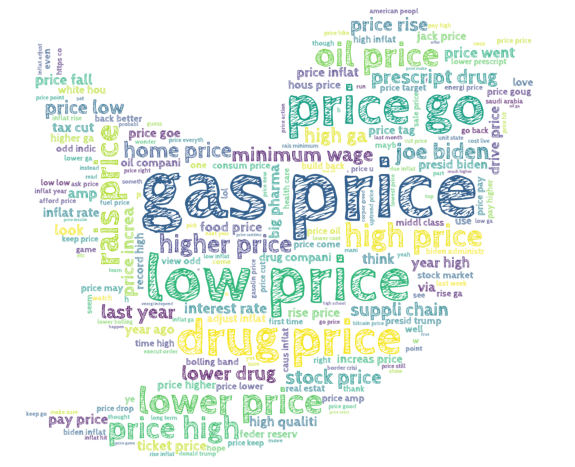

In [ ]:
twitter_mask = (np.array(Image.open('/content/drive/MyDrive/DDE/twird.png')).mean(axis=-1) == 0) * 255
wordcloud = WordCloud(
                      font_path='/content/drive/MyDrive/DDE/cabinsketch/CabinSketch-Bold.ttf',
                      background_color='white',
                      mask=twitter_mask
            ).generate(' '.join(df['cleaned_body'].values.tolist()))

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('/content/drive/MyDrive/DDE/twird1.png', dpi=300)
plt.show()

In [ ]:
colors = ['#1da1f2', '#33aaf3', '#4ab3f4', '#60bdf5', '#77c6f7', '#8ed0f8', '#a4d9f9', '#bbe2fb', '#d1ecfc', '#e8f5fd'][::-1]

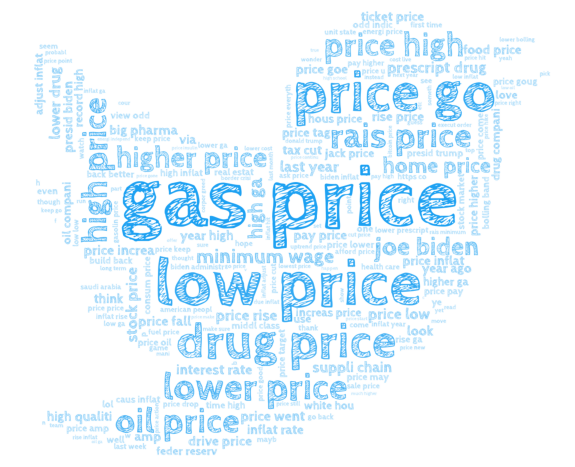

In [ ]:
twitter_mask = (np.array(Image.open('/content/drive/MyDrive/DDE/twird.png')).mean(axis=-1) == 0) * 255
wordcloud = WordCloud(
                      font_path='/content/drive/MyDrive/DDE/cabinsketch/CabinSketch-Bold.ttf',
                      background_color='white',
                      mask=twitter_mask,
                      color_func= lambda *args, **kwargs: colors[int((((kwargs['font_size'] -  4) / (200-4))  ** .25) * (len(colors)  - 1))], 
                      mode='RGBA'
            ).generate(' '.join(df['cleaned_body'].values.tolist()))

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('/content/drive/MyDrive/DDE/twird.png', dpi=300)
plt.show()

## Unigrams Distribution

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_n_words(corpus, n=None):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]
common_words = get_top_n_words(df['cleaned_body'] , 10)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

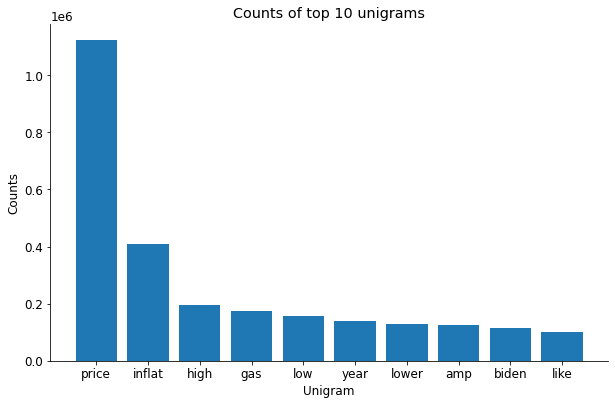

In [ ]:
plt.figure(figsize=(10,6))

plt.bar(x = unigram['unigram'], height = unigram['count'] )

plt.title('Counts of top 10 unigrams')
plt.ylabel('Counts')
plt.xlabel('Unigram')
sns.despine();

## Trigram Distribution

In [ ]:
def get_top_n_trigram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(3,3),stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in      vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]
common_words = get_top_n_trigram(df['cleaned_body'], 10)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

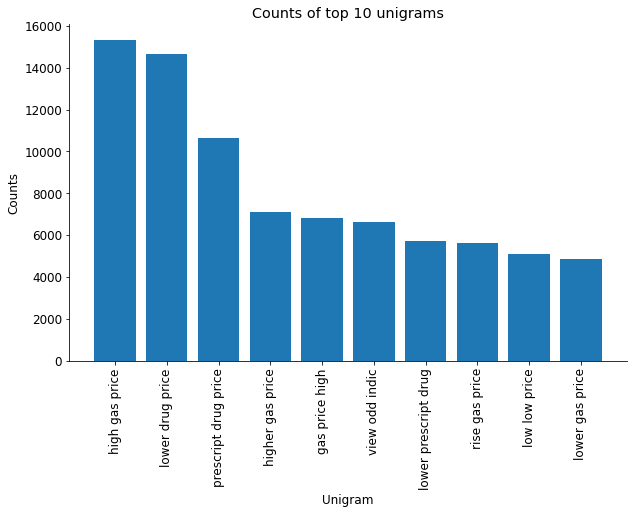

In [ ]:
plt.figure(figsize=(10,6))

plt.bar(x = trigram['trigram'], height = trigram['count'] )

plt.title('Counts of top 10 unigrams')
plt.ylabel('Counts')
plt.xlabel('Trigram')
plt.xticks(rotation=90)

sns.despine();

## LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
max_features=5000,# max number of unique words
                            )
data_matrix = vectorizer.fit_transform(df['cleaned_body'])
data_matrix

<1905898x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 18171965 stored elements in Compressed Sparse Row format>

In [ ]:

vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
max_features=5000,# max number of unique words
                            )
data_matrix = vectorizer.fit_transform(df['cleaned_body'])
data_matrix

In [ ]:
lda_model = LatentDirichletAllocation(
  n_components=10, # Number of topics
  learning_method='online',
  random_state=20,       
  n_jobs = -1  # Use all available CPUs
)
lda_output = lda_model.fit_transform(data_matrix)

In [ ]:
for i,topic in enumerate(lda_model.components_):
  print(f'Top 10 words for topic #{i}:')
  print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
  print('\n')

Top 10 words for topic #0:
['lower', 'suppli', 'cut', 'rise', 'high', 'go', 'higher', 'oil', 'gas', 'price']


Top 10 words for topic #1:
['billion', 'free', 'share', 'love', 'new', 'happen', 'govern', 'fed', 'amp', 'inflat']


Top 10 words for topic #2:
['econom', 'vote', 'spend', 'countri', 'tax', 'fall', 'presid', 'gas', 'trump', 'biden']


Top 10 words for topic #3:
['sinc', 'joe', 'last', 'let', 'high', 'month', 'time', 'low', 'go', 'price']


Top 10 words for topic #4:
['take', 'big', 'democrat', 'compani', 'cost', 'hous', 'rais', 'drug', 'lower', 'price']


Top 10 words for topic #5:
['pay', 'amp', 'job', 'use', 'still', 'say', 'american', 'wage', 'would', 'peopl']


Top 10 words for topic #6:
['rise', 'less', 'time', 'us', 'economi', 'increas', 'first', 'market', 'year', 'inflat']


Top 10 words for topic #7:
['one', 'chang', 'interest', 'real', 'see', 'like', 'look', 'home', 'rate', 'inflat']


Top 10 words for topic #8:
['today', 'high', 'crisi', 'move', 'reason', 'nation', '

In [ ]:
lda_model.components_

array([[1.00030149e-01, 1.00018592e-01, 1.00004440e-01, ...,
        1.00008249e-01, 1.00013576e-01, 1.00020275e-01],
       [1.00007903e-01, 5.62162062e+02, 1.00009957e-01, ...,
        1.00008576e-01, 1.00013224e-01, 1.00019004e-01],
       [1.00012814e-01, 1.00009504e-01, 1.00007600e-01, ...,
        1.00004728e-01, 1.00009464e-01, 1.00008756e-01],
       ...,
       [1.00009605e-01, 1.00013776e-01, 1.00008373e-01, ...,
        1.00017978e-01, 1.00016627e-01, 6.09016729e+02],
       [1.00007813e-01, 1.00018074e-01, 1.00004813e-01, ...,
        4.70995778e+02, 1.00018615e-01, 1.00036880e-01],
       [1.00012087e-01, 1.00015489e-01, 1.00004707e-01, ...,
        1.00018544e-01, 1.00016060e-01, 1.00017072e-01]])

In [ ]:

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=9949b94ac58d49524545ded7d339dcab459094e9961d4520867e727c4cfc2267
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.420952   8.115230       1        1  14.426616
0       0.648955  71.707100       2        1  12.271786
3      71.019684   9.971006       3        1  11.317841
5       3.785981  33.185135       4        1  10.966859
6     -42.666500  -9.222070       5        1  10.166528
4      -3.621689 -43.526516       6        1   9.612981
8      -3.632402  -4.171708       7        1   8.540813
2     -36.584400  35.804413       8        1   8.148756
7      44.391380  50.615383       9        1   7.817549
1      40.235809 -31.591665      10        1   6.730271, topic_info=        Term          Freq         Total Category  logprob  loglift
3412   price  1.108927e+06  1.108927e+06  Default  30.0000  30.0000
2263  inflat  4.123170e+05  4.123170e+05  Default  29.0000  29.0000
4967    year  1.387780e+05  1.387780e+05  Default  28.0000  28.0000
424    biden  1.185560e+05  1.185560e+05  Default  27.0000  27.0000
1856     gas  1.736420e+05  1.736420e+05  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
2263  inflat  5.471546e+04  4.123178e+05  Topic10  -3.2550   0.6789
2972     new  2.032976e+04  7.456005e+04  Topic10  -4.2450   1.3990
1888     get  1.358983e+04  1.375899e+05  Topic10  -4.6478   0.3836
1110     day  1.114902e+04  5.623022e+04  Topic10  -4.8458   1.0805
1310  dollar  9.539244e+03  2.952030e+04  Topic10  -5.0017   1.5689

[480 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
8         4  0.999948        abl
30        5  0.999890     accord
31        6  0.999901    account
43        1  0.999942        act
48        4  0.999953     actual
...     ...       ...        ...
4935      6  0.194863      would
4944     10  0.999927      wrong
4967      5  0.999995       year
4974      9  0.999918        yes
4976      8  0.999834  yesterday

[551 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 4, 6, 7, 5, 9, 3, 8, 2])

# Indices

## Vader

In [ ]:
sid = SentimentIntensityAnalyzer()
scores = df['body'].apply(lambda review: sid.polarity_scores(review))
df_vader_scores = pd.DataFrame(scores.values.tolist())

In [ ]:
pkl_save('vader_scores', df_vader_scores)

In [ ]:
df_vader_scores = pkl_load('vader_scores')

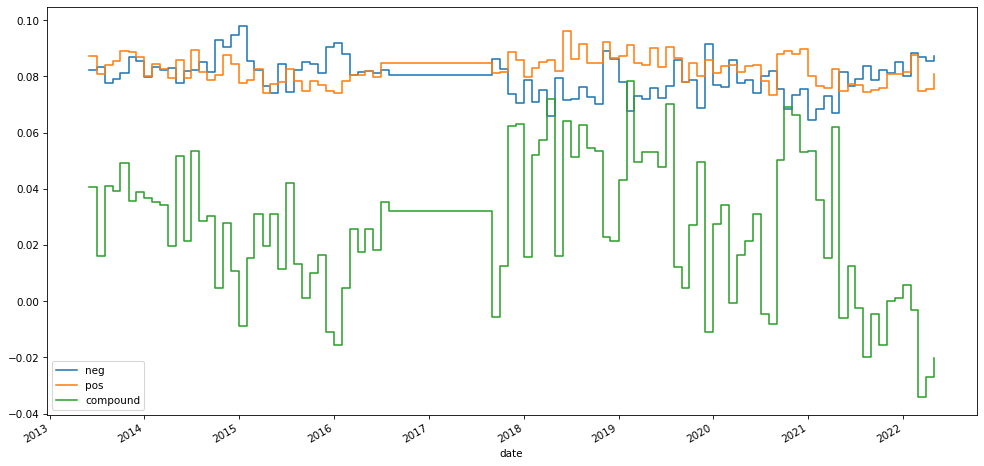

In [ ]:
daily_vader = aggregate_signal(df_vader_scores.values, df, 'tweet_dt')

df_monthly_vader = pd.DataFrame(aggregate_signal(daily_vader, df_day, 'year_month'),
                               columns = df_vader_scores.columns)

df_monthly_vader['date'] = pd.to_datetime(df_day['year_month'].unique() + '-01')
df_monthly_vader.drop(columns='neu').plot(x='date', drawstyle="steps-post")
plt.show()

## TF

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.002,  ngram_range=(2, 3), norm='l1', use_idf=False)
tf_embedding = vectorizer.fit_transform(df['cleaned_body'])
vocabulary = vectorizer.vocabulary_

In [ ]:
pkl_save('tf_scores', tf_embedding)
pkl_save('tf_vocabulary', vocabulary)

In [ ]:
tf_embedding = pkl_load('tf_scores')
vocabulary = pkl_load('tf_vocabulary')

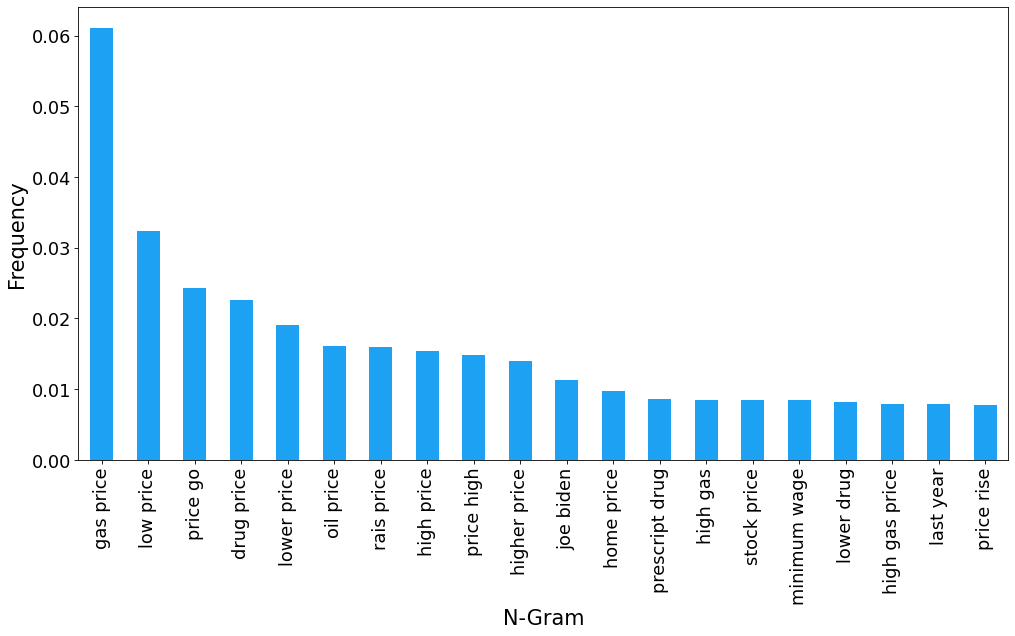

In [ ]:
matplotlib.rc('xtick', labelsize=17) 
matplotlib.rc('ytick', labelsize=17) 
word_freq = pd.DataFrame({'word': vocabulary.keys(), 'id': vocabulary.values()}).sort_values('id', ascending=True).reset_index(drop=True)
word_freq['df'] = np.array((tf_embedding > 0).mean(axis=0))[0]
ax = word_freq.sort_values('df', ascending=False).iloc[:20].plot.bar(x='word', y = 'df', color='#1DA1F2')
ax.get_legend().remove()
ax.set_xlabel('N-Gram', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

plt.show()

## Bert

In [ ]:
model = SentenceTransformer('all-distilroberta-v1')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
df_body_day = ['. '.join(group['body']) for date, group in df.groupby('tweet_dt')]
df_not_bot_body_day = ['. '.join(group['body']) for date, group in df_not_bot.groupby('tweet_dt')]
df_professionals_body_day = ['. '.join(group['body']) for date, group in df_professionals.groupby('tweet_dt')]
df_professionals_not_bot_body_day = ['. '.join(group['body']) for date, group in df_professionals_not_bot.groupby('tweet_dt')]

In [ ]:
day_agg_bert = model.encode(df_body_day, batch_size = 250, show_progress_bar = True)
day_agg_bert_not_bot = model.encode(df_not_bot_body_day, batch_size = 250, show_progress_bar = True)
day_agg_bert_professionals = model.encode(df_professionals_body_day, batch_size = 250, show_progress_bar = True)
day_agg_bert_professionals_not_bot = model.encode(df_professionals_not_bot_body_day, batch_size = 250, show_progress_bar = True)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
pkl_save('daily_bert', day_agg_bert) # Original
pkl_save('daily_bert_NB', day_agg_bert_not_bot) # Not-Bot
pkl_save('daily_bert_P', day_agg_bert_professionals) # Professionals
pkl_save('daily_bert_P_NB', day_agg_bert_professionals_not_bot) # Professionals Not-Bot

In [ ]:
day_agg_bert = pkl_load('daily_bert') # Original
day_agg_bert_not_bot = pkl_load('daily_bert_NB') # Not-Bot
day_agg_bert_professionals = pkl_load('daily_bert_P') # Professionals
day_agg_bert_professionals_not_bot = pkl_load('daily_bert_P_NB') # Professionals Not-Bot